- 참고 링크:
    - https://github.com/huggingface/transformers/blob/v4.33.0/src/transformers/models/bart/modeling_bart.py
    - https://huggingface.co/docs/transformers/model_doc/bart


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install accelerate>=0.20.1
!pip install transformers
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 23.2 MB/s eta 0:00:00


In [3]:
!pwd

/content


In [4]:
%cd /content/drive/MyDrive/Playdata_Python/final_project/transformers-4.33.0/src/transformers/

/content/drive/MyDrive/Playdata_Python/final_project/transformers-4.33.0/src/transformers


In [5]:
!ls

'=0.20.1'
 activations.py
 activations_tf.py
 audio_utils.py
 benchmark
 commands
 configuration_utils.py
 convert_graph_to_onnx.py
 convert_pytorch_checkpoint_to_tf2.py
 convert_slow_tokenizer.py
 convert_slow_tokenizers_checkpoints_to_fast.py
 convert_tf_hub_seq_to_seq_bert_to_pytorch.py
 data
 debug_utils.py
 deepspeed.py
 dependency_versions_check.py
 dependency_versions_table.py
 dynamic_module_utils.py
 feature_extraction_sequence_utils.py
 feature_extraction_utils.py
 file_utils.py
 generation_flax_utils.py
 generation_tf_utils.py
 generation_utils.py
 hf_argparser.py
 hyperparameter_search.py
 image_processing_utils.py
 image_transforms.py
 image_utils.py
 __init__.py
 keras_callbacks.py
 modelcard.py
 modeling_flax_outputs.py
 modeling_flax_pytorch_utils.py
 modeling_flax_utils.py
 modeling_outputs.py
 modeling_tf_outputs.py
 modeling_tf_pytorch_utils.py
 modeling_tf_utils.py
 modeling_utils.py
 models
 onnx
 optimization.py
 optimization_tf.py
 pipelines
 processing_utils.py


In [44]:
import copy
import math
import time
import warnings
from typing import List, Optional, Tuple, Union
from tqdm import tqdm

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader

from transformers.activations import ACT2FN
from transformers.modeling_outputs import (
    BaseModelOutput,
    BaseModelOutputWithPastAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    Seq2SeqLMOutput,
    Seq2SeqModelOutput,
    Seq2SeqQuestionAnsweringModelOutput,
    Seq2SeqSequenceClassifierOutput,
)
from transformers.modeling_utils import PreTrainedModel
from transformers.utils import (
    add_code_sample_docstrings,
    add_end_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
from transformers.models.bart.configuration_bart import BartConfig
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, BartConfig, BartForConditionalGeneration

import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# logger = logging.get_logger(__name__)

# _CHECKPOINT_FOR_DOC = "facebook/bart-base"
# _CONFIG_FOR_DOC = "BartConfig"

# # Base model docstring
# _EXPECTED_OUTPUT_SHAPE = [1, 8, 768]

# # SequenceClassification docstring
# _CHECKPOINT_FOR_SEQUENCE_CLASSIFICATION = "valhalla/bart-large-sst2"
# _SEQ_CLASS_EXPECTED_LOSS = 0.0
# _SEQ_CLASS_EXPECTED_OUTPUT = "'POSITIVE'"

# # QuestionAsnwering docstring
# _CHECKPOINT_FOR_QA = "valhalla/bart-large-finetuned-squadv1"
# _QA_EXPECTED_LOSS = 0.59
# _QA_EXPECTED_OUTPUT = "' nice puppet'"

# BART_PRETRAINED_MODEL_ARCHIVE_LIST = [
#     "facebook/bart-large",
#     # see all BART models at https://huggingface.co/models?filter=bart
# ]

# 1. 데이터 불러오기

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Playdata_Python/final_project/data/summary_dataset/01.news_r.csv')
dataset.shape

(10800, 2)

In [84]:
# 데이터 분할
train_df = dataset[:7000]
valid_df = dataset[7000:8900]
test_df = dataset[8900:]

train_df.shape, valid_df.shape, test_df.shape

((7000, 2), (1900, 2), (1900, 2))

In [85]:
input_train = train_df['passage']
target_train = train_df['summary1']

input_valid = valid_df['passage']
target_valid = valid_df['summary1']

input_test = test_df['passage']
target_test = test_df['summary1']

input_train.shape, target_train.shape

((7000,), (7000,))

# 2. pretrained 모델 구조 파악

### 2-1. pretrained 모델 및 토크나이저 불러오기

In [8]:
model_name = 'hyunwoongko/kobart'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [38]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

### 2-2. pretrained 모델 성능 테스트

In [40]:
original_sen_list = input_test.tolist()  # 신문 원본
summary_sen_list = target_test.tolist()  # 신문 요약본

original_sen_list[:2], summary_sen_list[:2]

(['정은경 질병관리청장과 봉준호 감독이 미국의 시사주간지 타임(Time)이 선정하는 ‘2020 세계에서 가장 영향력 있는 100인’ 명단에 나란히 이름을 올렸다. 청와대 관계자는 23일 “이번 선정은 K방역이 전 세계가 본받아야 할 모범으로 인정받았다는 점을 확인해주는 데 의미가 있다”며 “방역과 관련해 뛰어난 성과와 업적을 보인다는 점에서 정 청장을 선정한 것”이라고 말했다. 정 청장은 리더스 부분에 등재됐다. 아티스트 부분에 이름을 올린 봉 감독에 대해서도 “매우 기쁜 소식이며 축하의 말씀을 전한다”고 했다. 특히 문재인 대통령은 정 청장에 대한 소개글을 타임에 전달했다. 선정된 100인 소개글 가운데 현직 대통령의 글은 문 대통령이 유일하다.  문 대통령은 소개글에서 “코로나19 팬데믹 상황에서 한국의 방역은 세계의 모범이 됐고, 정 청장은 방역의 최전방에서 국민과 진솔하게 소통해 K방역을 성공으로 이끌었다”고 적었다. 이어 “한국에 첫 확진자가 발생했을 때 정 청장은 정부를 대표해 국민 앞에 섰고 매일 투명하게 상황을 발표했다”며 “질병관리청 최초의 여성 수장으로서 코로나 발생 6개월 전부터 ‘원인불명 집단감염 대응절차’ 매뉴얼을 마련하는 등 질병관리청을 준비된 조직으로 이끌었다”고 평가했다. 문 대통령은 알베르 카뮈의 소설 『페스트』에 등장하는 ‘페스트와 싸우는 유일한 방법은 성실성’이라는 문구를 인용하며 “정 청장의 성실성이야말로 세계 곳곳에서 코로나와 맞서는 수많은 ‘정은경’들에게, 그리고 포스트 코로나 시대를 연 인류 모두에게 영감을 주는 얘기”라고 강조했다. 앞서 문 대통령은 지난 11일 충북 청주에 있는 질병관리본부(질본)를 찾아 정 청장에게 임명장을 수여했다. 정 청장은 차관급이다. 이번 정부 들어 장ㆍ차관급을 통틀어 문 대통령이 현장을 찾아 임명식을 진행한 것은 이때가 처음이다. 이와 관련 청와대 관계자는 “전쟁 중에 야전사령관을 불러 임명장을 주는 것이 아닌 직접 가서 임명장을 드리는 것이기 때문에 초대 청장에 대한 신뢰와 기대 의미를

In [52]:
# 한글 텍스트를 토큰화하고 요약된 결과를 리스트에 저장하는 테스트
summary_sen_by_model_list = []

for original_sen in original_sen_list[:20]:
    # 문장을 토큰화
    input_ids = tokenizer.encode(original_sen, return_tensors="pt")

    # 모델을 사용하여 요약 생성
    summary_ids = model.generate(input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)

    # 요약 결과를 디코딩하여 텍스트로 변환
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    summary_sen_by_model_list.append(summary_text)

summary_sen_by_model_list[:5]

['했다. 정은경 질병관리청장과 봉준호 감독이 미국의 시사주간지 타임(Time)이 선정하는 ‘2020 세계에서 가장 영향력 있는 100인’ 명단에 나란히 이름을 올렸다. 청와대 관계자는 23일 “이번 선정은 K방역이 전 세계가 본받아야 할 모범으로 인정받았다는 점을 확인해주는 데 의미가 있다”며 “방역과 관련해 뛰어난 성과와 업적을 보인다는 점에서 정 청장을 선정한 것”이라고 말했다. 정 청장은 리더스 부분에 등재됐다. 아티스트 부분에 이름을 올린 봉 감독에 대해서도 “매우 기쁜 소식이며 축하의 말씀을 전한다”고 했다. 특히 문재인 대통령은 정 청장에 대한 소개글을 타임에 전달했다. 선정된 100인 소개글 가운데 현직 대통령의 글은 문 대통령이 유일하다.  문 대통령은 소개글',
 '있다.\n 창업가는 기존에 없던 방식으로 고객이 절실하게 필요로 하는 제품을 만들고 개선함으로써 혁신을 만든다. 그리고 그런 제품을 만들기 위해 창업가 스스로가 마치 인간을 탐구하는 학자처럼 직접적인 고객 관찰과 공감 과정을 반드시 거쳐야 한다. 집에서, 학교에서, 직장에서 고객이 어떤 행동을 하고 살고 있으며, 어느 부분에서 짜증과 고통을 느끼는지를 모두 파악하는 것이다. 바로 이 짜증과 고통의 부분을 해결하면서 혁신이 시작된다. 잘못된 문제에 집중하지 말라자기중심적으로 사고하며 고객도 창업가와 같은 심각한 문제를 갖고 해결하고 싶어할 것이라 믿는 바람에 실패하는 경우를 목격한다. 어떤 손실을 감내하더라도 자기만족을 위해 창업하는 것이라면 전혀 문제가 될 것이 없지만, 그렇지 않은 경우 자기중심적 사고는 창업가에게 참으로 위험한 자세라고 보인',
 '',
 '했다. 기대가 너무 큰 탓이었을까. 소문난 잔치엔 먹을 게 없었다. 미국의 전기자동차 기업 테슬라가 22일(현지시간) 개최한 주주총회 겸 ‘배터리 데이’ 얘기다. 테슬라 최고경영자(CEO) 일론 머스크가 지난 4월 “테슬라 역사상 최고로 신나는 날이 될 것”이라고 트윗을 날린 뒤 배터리 데이는 테슬라의 주가 상승을 견인한 호

In [55]:
# BLEU 점수 계산
nltk.download('punkt')

# 문장을 토큰 리스트로 변환하는 함수
def tokenize_sentence(sentence):
    return nltk.word_tokenize(sentence)

num_sentences = 20  # 20개로 test
total_belu_score = []

for i in range(num_sentences):

    # Reference 문장과 Candidate 문장 토큰화
    reference_tokens = tokenize_sentence(summary_sen_list[i])
    candidate_tokens = tokenize_sentence(summary_sen_by_model_list[i])

    # BLEU Score 계산
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))  # (원본 번역문, 모델 번역문)
    total_belu_score.append(bleu_score)

    if i < 20:
        # BLEU 점수 출력
        print(f"{i}번째 | 원본 번역본: {summary_sen_list[i]}")
        print(f"{i}번째 | 모델 번역본: {summary_sen_by_model_list[i]}")
        print(f"{i}번째 | BLEU 점수: {bleu_score}")
        print("----------------------------------------------------------------------------------------------------")
    else:
        pass

# 전체 blue 평균 계산
average_bleu_score = sum(total_belu_score) / num_sentences
print(f"100문장에 대한 Belu Score 평균: {average_bleu_score}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


0번째 | 원본 번역본: 정 청장과 봉 감독이 2020 세계에서 가장 영향력 있는 100인 명단에 오르자 청와대 관계자는 K방역이 모범으로 인정받았음을 확인했다고 말하며 봉 감독에게는 축하를 전했다.
0번째 | 모델 번역본: 했다. 정은경 질병관리청장과 봉준호 감독이 미국의 시사주간지 타임(Time)이 선정하는 ‘2020 세계에서 가장 영향력 있는 100인’ 명단에 나란히 이름을 올렸다. 청와대 관계자는 23일 “이번 선정은 K방역이 전 세계가 본받아야 할 모범으로 인정받았다는 점을 확인해주는 데 의미가 있다”며 “방역과 관련해 뛰어난 성과와 업적을 보인다는 점에서 정 청장을 선정한 것”이라고 말했다. 정 청장은 리더스 부분에 등재됐다. 아티스트 부분에 이름을 올린 봉 감독에 대해서도 “매우 기쁜 소식이며 축하의 말씀을 전한다”고 했다. 특히 문재인 대통령은 정 청장에 대한 소개글을 타임에 전달했다. 선정된 100인 소개글 가운데 현직 대통령의 글은 문 대통령이 유일하다.  문 대통령은 소개글
0번째 | BLEU 점수: 0.13513513513513517
----------------------------------------------------------------------------------------------------
1번째 | 원본 번역본: 인간을 탐구하는 학자와 같이 창업가는 고객이 집 등에서 어떤 행동을 하는지 관찰하고 어떤 부분에서 짜증을 느끼는지 공감하는 과정을 통해 기존에 없던 방식으로 혁신을 만든다.
1번째 | 모델 번역본: 있다.
 창업가는 기존에 없던 방식으로 고객이 절실하게 필요로 하는 제품을 만들고 개선함으로써 혁신을 만든다. 그리고 그런 제품을 만들기 위해 창업가 스스로가 마치 인간을 탐구하는 학자처럼 직접적인 고객 관찰과 공감 과정을 반드시 거쳐야 한다. 집에서, 학교에서, 직장에서 고객이 어떤 행동을 하고 살고 있으며, 어느 부분에서 짜증과 고통을 느끼는지를 모두 파악하는 것이다. 바로 이 짜증과 고통의 부분을 해결하면서

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

# 3. modeling_bart.py 불러오기

### 3-1. modeling_bart.py 내 함수 불러오기

In [10]:
# def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
#     """
#     Shift input ids one token to the right.
#     """
#     shifted_input_ids = input_ids.new_zeros(input_ids.shape)
#     shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
#     shifted_input_ids[:, 0] = decoder_start_token_id

#     if pad_token_id is None:
#         raise ValueError("self.model.config.pad_token_id has to be defined.")
#     # replace possible -100 values in labels by `pad_token_id`
#     shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)

#     return shifted_input_ids


# def _make_causal_mask(
#     input_ids_shape: torch.Size, dtype: torch.dtype, device: torch.device, past_key_values_length: int = 0
# ):
#     """
#     Make causal mask used for bi-directional self-attention.
#     """
#     bsz, tgt_len = input_ids_shape
#     mask = torch.full((tgt_len, tgt_len), torch.finfo(dtype).min, device=device)
#     mask_cond = torch.arange(mask.size(-1), device=device)
#     mask.masked_fill_(mask_cond < (mask_cond + 1).view(mask.size(-1), 1), 0)
#     mask = mask.to(dtype)

#     if past_key_values_length > 0:
#         mask = torch.cat([torch.zeros(tgt_len, past_key_values_length, dtype=dtype, device=device), mask], dim=-1)
#     return mask[None, None, :, :].expand(bsz, 1, tgt_len, tgt_len + past_key_values_length)


# def _expand_mask(mask: torch.Tensor, dtype: torch.dtype, tgt_len: Optional[int] = None):
#     """
#     Expands attention_mask from `[bsz, seq_len]` to `[bsz, 1, tgt_seq_len, src_seq_len]`.
#     """
#     bsz, src_len = mask.size()
#     tgt_len = tgt_len if tgt_len is not None else src_len

#     expanded_mask = mask[:, None, None, :].expand(bsz, 1, tgt_len, src_len).to(dtype)

#     inverted_mask = 1.0 - expanded_mask

#     return inverted_mask.masked_fill(inverted_mask.to(torch.bool), torch.finfo(dtype).min)

### 3-2. BartLearnedPositionalEmbedding 불러오기

In [11]:
# class BartLearnedPositionalEmbedding(nn.Embedding):
#     """
#     This module learns positional embeddings up to a fixed maximum size.
#     """

#     def __init__(self, num_embeddings: int, embedding_dim: int):
#         # Bart is set up so that if padding_idx is specified then offset the embedding ids by 2
#         # and adjust num_embeddings appropriately. Other models don't have this hack
#         self.offset = 2
#         super().__init__(num_embeddings + self.offset, embedding_dim)

#     def forward(self, input_ids: torch.Tensor, past_key_values_length: int = 0):
#         """`input_ids' shape is expected to be [bsz x seqlen]."""

#         bsz, seq_len = input_ids.shape[:2]
#         positions = torch.arange(
#             past_key_values_length, past_key_values_length + seq_len, dtype=torch.long, device=self.weight.device
#         ).expand(bsz, -1)

#         return super().forward(positions + self.offset)

### 3-3. BartAttention 불러오기

In [12]:
# class BartAttention(nn.Module):
#     """Multi-headed attention from 'Attention Is All You Need' paper"""

#     def __init__(
#         self,
#         embed_dim: int,
#         num_heads: int,
#         dropout: float = 0.0,
#         is_decoder: bool = False,
#         bias: bool = True,
#     ):
#         super().__init__()
#         self.embed_dim = embed_dim
#         self.num_heads = num_heads
#         self.dropout = dropout
#         self.head_dim = embed_dim // num_heads

#         if (self.head_dim * num_heads) != self.embed_dim:
#             raise ValueError(
#                 f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
#                 f" and `num_heads`: {num_heads})."
#             )
#         self.scaling = self.head_dim**-0.5
#         self.is_decoder = is_decoder

#         self.k_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
#         self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
#         self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
#         self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)

#     def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
#         return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

#     def forward(
#         self,
#         hidden_states: torch.Tensor,
#         key_value_states: Optional[torch.Tensor] = None,
#         past_key_value: Optional[Tuple[torch.Tensor]] = None,
#         attention_mask: Optional[torch.Tensor] = None,
#         layer_head_mask: Optional[torch.Tensor] = None,
#         output_attentions: bool = False,
#     ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
#         """Input shape: Batch x Time x Channel"""

#         # if key_value_states are provided this layer is used as a cross-attention layer
#         # for the decoder
#         is_cross_attention = key_value_states is not None

#         bsz, tgt_len, _ = hidden_states.size()

#         # get query proj
#         query_states = self.q_proj(hidden_states) * self.scaling
#         # get key, value proj
#         # `past_key_value[0].shape[2] == key_value_states.shape[1]`
#         # is checking that the `sequence_length` of the `past_key_value` is the same as
#         # the provided `key_value_states` to support prefix tuning
#         if (
#             is_cross_attention
#             and past_key_value is not None
#             and past_key_value[0].shape[2] == key_value_states.shape[1]
#         ):
#             # reuse k,v, cross_attentions
#             key_states = past_key_value[0]
#             value_states = past_key_value[1]
#         elif is_cross_attention:
#             # cross_attentions
#             key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
#             value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
#         elif past_key_value is not None:
#             # reuse k, v, self_attention
#             key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
#             value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
#             key_states = torch.cat([past_key_value[0], key_states], dim=2)
#             value_states = torch.cat([past_key_value[1], value_states], dim=2)
#         else:
#             # self_attention
#             key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
#             value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

#         if self.is_decoder:
#             # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
#             # Further calls to cross_attention layer can then reuse all cross-attention
#             # key/value_states (first "if" case)
#             # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
#             # all previous decoder key/value_states. Further calls to uni-directional self-attention
#             # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
#             # if encoder bi-directional self-attention `past_key_value` is always `None`
#             past_key_value = (key_states, value_states)

#         proj_shape = (bsz * self.num_heads, -1, self.head_dim)
#         query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
#         key_states = key_states.reshape(*proj_shape)
#         value_states = value_states.reshape(*proj_shape)

#         src_len = key_states.size(1)
#         attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))

#         if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
#             raise ValueError(
#                 f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
#                 f" {attn_weights.size()}"
#             )

#         if attention_mask is not None:
#             if attention_mask.size() != (bsz, 1, tgt_len, src_len):
#                 raise ValueError(
#                     f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
#                 )
#             attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
#             attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

#         attn_weights = nn.functional.softmax(attn_weights, dim=-1)

#         if layer_head_mask is not None:
#             if layer_head_mask.size() != (self.num_heads,):
#                 raise ValueError(
#                     f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
#                     f" {layer_head_mask.size()}"
#                 )
#             attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
#             attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

#         if output_attentions:
#             # this operation is a bit awkward, but it's required to
#             # make sure that attn_weights keeps its gradient.
#             # In order to do so, attn_weights have to be reshaped
#             # twice and have to be reused in the following
#             attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
#             attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
#         else:
#             attn_weights_reshaped = None

#         attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

#         attn_output = torch.bmm(attn_probs, value_states)

#         if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
#             raise ValueError(
#                 f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
#                 f" {attn_output.size()}"
#             )

#         attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
#         attn_output = attn_output.transpose(1, 2)

#         # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
#         # partitioned across GPUs when using tensor-parallelism.
#         attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

#         attn_output = self.out_proj(attn_output)

#         return attn_output, attn_weights_reshaped, past_key_value

### 3-4. BartPreTrainedModel 불러오기

In [13]:
# class BartPreTrainedModel(PreTrainedModel):
#     config_class = BartConfig
#     base_model_prefix = "model"
#     supports_gradient_checkpointing = True
#     _keys_to_ignore_on_load_unexpected = ["encoder.version", "decoder.version"]
#     _no_split_modules = [r"BartEncoderLayer", r"BartDecoderLayer"]
#     _skip_keys_device_placement = "past_key_values"

#     def _init_weights(self, module):
#         std = self.config.init_std
#         if isinstance(module, nn.Linear):
#             module.weight.data.normal_(mean=0.0, std=std)
#             if module.bias is not None:
#                 module.bias.data.zero_()
#         elif isinstance(module, nn.Embedding):
#             module.weight.data.normal_(mean=0.0, std=std)
#             if module.padding_idx is not None:
#                 module.weight.data[module.padding_idx].zero_()

#     def _set_gradient_checkpointing(self, module, value=False):
#         if isinstance(module, (BartDecoder, model.get_encoder())):  # BartEncoder -> model.get_encoder()
#             module.gradient_checkpointing = value

#     @property
#     def dummy_inputs(self):
#         pad_token = self.config.pad_token_id
#         input_ids = torch.tensor([[0, 6, 10, 4, 2], [0, 8, 12, 2, pad_token]], device=self.device)
#         dummy_inputs = {
#             "attention_mask": input_ids.ne(pad_token),
#             "input_ids": input_ids,
#         }
#         return dummy_inputs

### 3-5. BartDecoderLayer 불러오기

In [14]:
# class BartDecoderLayer(nn.Module):
#     def __init__(self, config: BartConfig):
#         super().__init__()
#         self.embed_dim = config.d_model

#         self.self_attn = BartAttention(
#             embed_dim=self.embed_dim,
#             num_heads=config.decoder_attention_heads,
#             dropout=config.attention_dropout,
#             is_decoder=True,
#         )
#         self.dropout = config.dropout
#         self.activation_fn = ACT2FN[config.activation_function]
#         self.activation_dropout = config.activation_dropout

#         self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
#         self.encoder_attn = BartAttention(
#             self.embed_dim,
#             config.decoder_attention_heads,
#             dropout=config.attention_dropout,
#             is_decoder=True,
#         )
#         self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
#         self.fc1 = nn.Linear(self.embed_dim, config.decoder_ffn_dim)
#         self.fc2 = nn.Linear(config.decoder_ffn_dim, self.embed_dim)
#         self.final_layer_norm = nn.LayerNorm(self.embed_dim)

#     def forward(
#         self,
#         hidden_states: torch.Tensor,
#         attention_mask: Optional[torch.Tensor] = None,
#         encoder_hidden_states: Optional[torch.Tensor] = None,
#         encoder_attention_mask: Optional[torch.Tensor] = None,
#         layer_head_mask: Optional[torch.Tensor] = None,
#         cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
#         past_key_value: Optional[Tuple[torch.Tensor]] = None,
#         output_attentions: Optional[bool] = False,
#         use_cache: Optional[bool] = True,
#     ) -> Tuple[torch.FloatTensor, Optional[Tuple[torch.FloatTensor, torch.FloatTensor]]]:
#         """
#         Args:
#             hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
#             attention_mask (`torch.FloatTensor`): attention mask of size
#                 `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
#             encoder_hidden_states (`torch.FloatTensor`):
#                 cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
#             encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
#                 `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
#             layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
#                 `(encoder_attention_heads,)`.
#             cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
#                 size `(decoder_attention_heads,)`.
#             past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
#             output_attentions (`bool`, *optional*):
#                 Whether or not to return the attentions tensors of all attention layers. See `attentions` under
#                 returned tensors for more detail.
#         """
#         residual = hidden_states

#         # Self Attention
#         # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
#         self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
#         # add present self-attn cache to positions 1,2 of present_key_value tuple
#         hidden_states, self_attn_weights, present_key_value = self.self_attn(
#             hidden_states=hidden_states,
#             past_key_value=self_attn_past_key_value,
#             attention_mask=attention_mask,
#             layer_head_mask=layer_head_mask,
#             output_attentions=output_attentions,
#         )
#         hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
#         hidden_states = residual + hidden_states
#         hidden_states = self.self_attn_layer_norm(hidden_states)

#         # Cross-Attention Block
#         cross_attn_present_key_value = None
#         cross_attn_weights = None
#         if encoder_hidden_states is not None:
#             residual = hidden_states

#             # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
#             cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
#             hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
#                 hidden_states=hidden_states,
#                 key_value_states=encoder_hidden_states,
#                 attention_mask=encoder_attention_mask,
#                 layer_head_mask=cross_attn_layer_head_mask,
#                 past_key_value=cross_attn_past_key_value,
#                 output_attentions=output_attentions,
#             )
#             hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
#             hidden_states = residual + hidden_states
#             hidden_states = self.encoder_attn_layer_norm(hidden_states)

#             # add cross-attn to positions 3,4 of present_key_value tuple
#             present_key_value = present_key_value + cross_attn_present_key_value

#         # Fully Connected
#         residual = hidden_states
#         hidden_states = self.activation_fn(self.fc1(hidden_states))
#         hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
#         hidden_states = self.fc2(hidden_states)
#         hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
#         hidden_states = residual + hidden_states
#         hidden_states = self.final_layer_norm(hidden_states)

#         outputs = (hidden_states,)

#         if output_attentions:
#             outputs += (self_attn_weights, cross_attn_weights)

#         if use_cache:
#             outputs += (present_key_value,)

#         return outputs

### 3-5. BartDecoder 재정의

In [15]:
# class BartDecoder(BartPreTrainedModel):
#     """
#     Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`BartDecoderLayer`]

#     Args:
#         config: BartConfig
#         embed_tokens (nn.Embedding): output embedding
#     """

#     def __init__(self, config: BartConfig, embed_tokens: Optional[nn.Embedding] = None):
#         super().__init__(config)
#         self.dropout = config.dropout
#         self.layerdrop = config.decoder_layerdrop
#         self.padding_idx = config.pad_token_id
#         self.max_target_positions = config.max_position_embeddings
#         self.embed_scale = math.sqrt(config.d_model) if config.scale_embedding else 1.0

#         self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model, self.padding_idx)

#         if embed_tokens is not None:
#             self.embed_tokens.weight = embed_tokens.weight

#         self.embed_positions = BartLearnedPositionalEmbedding(
#             config.max_position_embeddings,
#             config.d_model,
#         )
#         self.layers = nn.ModuleList([BartDecoderLayer(config) for _ in range(config.decoder_layers)])
#         self.layernorm_embedding = nn.LayerNorm(config.d_model)

#         self.gradient_checkpointing = False
#         # Initialize weights and apply final processing
#         self.post_init()

#     def get_input_embeddings(self):
#         return self.embed_tokens

#     def set_input_embeddings(self, value):
#         self.embed_tokens = value

#     def _prepare_decoder_attention_mask(self, attention_mask, input_shape, inputs_embeds, past_key_values_length):
#         # create causal mask
#         # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
#         combined_attention_mask = None
#         if input_shape[-1] > 1:
#             combined_attention_mask = _make_causal_mask(
#                 input_shape,
#                 inputs_embeds.dtype,
#                 device=inputs_embeds.device,
#                 past_key_values_length=past_key_values_length,
#             )

#         if attention_mask is not None:
#             # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
#             expanded_attn_mask = _expand_mask(attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1]).to(
#                 inputs_embeds.device
#             )
#             combined_attention_mask = (
#                 expanded_attn_mask if combined_attention_mask is None else expanded_attn_mask + combined_attention_mask
#             )

#         return combined_attention_mask

#     def forward(
#         self,
#         input_ids: torch.LongTensor = None,
#         attention_mask: Optional[torch.Tensor] = None,
#         encoder_hidden_states: Optional[torch.FloatTensor] = None,
#         encoder_attention_mask: Optional[torch.LongTensor] = None,
#         head_mask: Optional[torch.Tensor] = None,
#         cross_attn_head_mask: Optional[torch.Tensor] = None,
#         past_key_values: Optional[List[torch.FloatTensor]] = None,
#         inputs_embeds: Optional[torch.FloatTensor] = None,
#         use_cache: Optional[bool] = None,
#         output_attentions: Optional[bool] = None,
#         output_hidden_states: Optional[bool] = None,
#         return_dict: Optional[bool] = None,
#     ) -> Union[Tuple, BaseModelOutputWithPastAndCrossAttentions]:
#         r"""
#         Args:
#             input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
#                 Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
#                 provide it.

#                 Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
#                 [`PreTrainedTokenizer.__call__`] for details.

#                 [What are input IDs?](../glossary#input-ids)
#             attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
#                 Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

#                 - 1 for tokens that are **not masked**,
#                 - 0 for tokens that are **masked**.

#                 [What are attention masks?](../glossary#attention-mask)
#             encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
#                 Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
#                 of the decoder.
#             encoder_attention_mask (`torch.LongTensor` of shape `(batch_size, encoder_sequence_length)`, *optional*):
#                 Mask to avoid performing cross-attention on padding tokens indices of encoder input_ids. Mask values
#                 selected in `[0, 1]`:

#                 - 1 for tokens that are **not masked**,
#                 - 0 for tokens that are **masked**.

#                 [What are attention masks?](../glossary#attention-mask)
#             head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
#                 Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

#                 - 1 indicates the head is **not masked**,
#                 - 0 indicates the head is **masked**.

#             cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
#                 Mask to nullify selected heads of the cross-attention modules in the decoder to avoid performing
#                 cross-attention on hidden heads. Mask values selected in `[0, 1]`:

#                 - 1 indicates the head is **not masked**,
#                 - 0 indicates the head is **masked**.

#             past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
#                 Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
#                 shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
#                 shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

#                 Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
#                 cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

#                 If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
#                 that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
#                 all `decoder_input_ids` of shape `(batch_size, sequence_length)`. inputs_embeds (`torch.FloatTensor` of
#                 shape `(batch_size, sequence_length, hidden_size)`, *optional*): Optionally, instead of passing
#                 `input_ids` you can choose to directly pass an embedded representation. This is useful if you want more
#                 control over how to convert `input_ids` indices into associated vectors than the model's internal
#                 embedding lookup matrix.
#             output_attentions (`bool`, *optional*):
#                 Whether or not to return the attentions tensors of all attention layers. See `attentions` under
#                 returned tensors for more detail.
#             output_hidden_states (`bool`, *optional*):
#                 Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
#                 for more detail.
#             return_dict (`bool`, *optional*):
#                 Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
#         """
#         output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
#         output_hidden_states = (
#             output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
#         )
#         use_cache = use_cache if use_cache is not None else self.config.use_cache
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         # retrieve input_ids and inputs_embeds
#         if input_ids is not None and inputs_embeds is not None:
#             raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
#         elif input_ids is not None:
#             input = input_ids
#             input_shape = input.shape
#             input_ids = input_ids.view(-1, input_shape[-1])
#         elif inputs_embeds is not None:
#             input_shape = inputs_embeds.size()[:-1]
#             input = inputs_embeds[:, :, -1]
#         else:
#             raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

#         # past_key_values_length
#         past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

#         if inputs_embeds is None:
#             inputs_embeds = self.embed_tokens(input) * self.embed_scale

#         attention_mask = self._prepare_decoder_attention_mask(
#             attention_mask, input_shape, inputs_embeds, past_key_values_length
#         )

#         # expand encoder attention mask
#         if encoder_hidden_states is not None and encoder_attention_mask is not None:
#             # [bsz, seq_len] -> [bsz, 1, tgt_seq_len, src_seq_len]
#             encoder_attention_mask = _expand_mask(encoder_attention_mask, inputs_embeds.dtype, tgt_len=input_shape[-1])

#         # embed positions
#         positions = self.embed_positions(input, past_key_values_length)
#         positions = positions.to(inputs_embeds.device)

#         hidden_states = inputs_embeds + positions
#         hidden_states = self.layernorm_embedding(hidden_states)

#         hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

#         if self.gradient_checkpointing and self.training:
#             if use_cache:
#                 logger.warning_once(
#                     "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
#                 )
#                 use_cache = False

#         # decoder layers
#         all_hidden_states = () if output_hidden_states else None
#         all_self_attns = () if output_attentions else None
#         all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
#         next_decoder_cache = () if use_cache else None

#         # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
#         for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
#             if attn_mask is not None:
#                 if attn_mask.size()[0] != (len(self.layers)):
#                     raise ValueError(
#                         f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
#                         f" {head_mask.size()[0]}."
#                     )

#         for idx, decoder_layer in enumerate(self.layers):
#             # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
#             if output_hidden_states:
#                 all_hidden_states += (hidden_states,)
#             if self.training:
#                 dropout_probability = torch.rand([])
#                 if dropout_probability < self.layerdrop:
#                     continue

#             past_key_value = past_key_values[idx] if past_key_values is not None else None

#             if self.gradient_checkpointing and self.training:

#                 def create_custom_forward(module):
#                     def custom_forward(*inputs):
#                         # None for past_key_value
#                         return module(*inputs, output_attentions, use_cache)

#                     return custom_forward

#                 layer_outputs = torch.utils.checkpoint.checkpoint(
#                     create_custom_forward(decoder_layer),
#                     hidden_states,
#                     attention_mask,
#                     encoder_hidden_states,
#                     encoder_attention_mask,
#                     head_mask[idx] if head_mask is not None else None,
#                     cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
#                     None,
#                 )
#             else:
#                 layer_outputs = decoder_layer(
#                     hidden_states,
#                     attention_mask=attention_mask,
#                     encoder_hidden_states=encoder_hidden_states,
#                     encoder_attention_mask=encoder_attention_mask,
#                     layer_head_mask=(head_mask[idx] if head_mask is not None else None),
#                     cross_attn_layer_head_mask=(
#                         cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
#                     ),
#                     past_key_value=past_key_value,
#                     output_attentions=output_attentions,
#                     use_cache=use_cache,
#                 )
#             hidden_states = layer_outputs[0]

#             if use_cache:
#                 next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

#             if output_attentions:
#                 all_self_attns += (layer_outputs[1],)

#                 if encoder_hidden_states is not None:
#                     all_cross_attentions += (layer_outputs[2],)

#         # add hidden states from the last decoder layer
#         if output_hidden_states:
#             all_hidden_states += (hidden_states,)

#         next_cache = next_decoder_cache if use_cache else None
#         if not return_dict:
#             return tuple(
#                 v
#                 for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
#                 if v is not None
#             )
#         return BaseModelOutputWithPastAndCrossAttentions(
#             last_hidden_state=hidden_states,
#             past_key_values=next_cache,
#             hidden_states=all_hidden_states,
#             attentions=all_self_attns,
#             cross_attentions=all_cross_attentions,
#         )

### 3-6. BartModel 불러오기

In [16]:
# # @add_start_docstrings(
# #     "The bare BART Model outputting raw hidden-states without any specific head on top.",
# #     BART_START_DOCSTRING,
# # )
# class BartModel(BartPreTrainedModel):
#     _tied_weights_keys = ["encoder.embed_tokens.weight", "decoder.embed_tokens.weight"]

#     def __init__(self, config: BartConfig):
#         super().__init__(config)

#         padding_idx, vocab_size = config.pad_token_id, config.vocab_size
#         self.shared = nn.Embedding(vocab_size, config.d_model, padding_idx)

#         self.encoder = model.get_encoder()
#         self.decoder = BartDecoder(config, self.shared)

#         # Initialize weights and apply final processing
#         self.post_init()

#     def get_input_embeddings(self):
#         return self.shared

#     def set_input_embeddings(self, value):
#         self.shared = value
#         self.encoder.embed_tokens = self.shared
#         self.decoder.embed_tokens = self.shared

#     def get_encoder(self):
#         return self.encoder

#     def get_decoder(self):
#         return self.decoder

#     # @add_start_docstrings_to_model_forward(BART_INPUTS_DOCSTRING)
#     @add_code_sample_docstrings(
#         checkpoint=_CHECKPOINT_FOR_DOC,
#         output_type=Seq2SeqModelOutput,
#         config_class=_CONFIG_FOR_DOC,
#         expected_output=_EXPECTED_OUTPUT_SHAPE,
#     )
#     def forward(
#         self,
#         input_ids: torch.LongTensor = None,
#         attention_mask: Optional[torch.Tensor] = None,
#         decoder_input_ids: Optional[torch.LongTensor] = None,
#         decoder_attention_mask: Optional[torch.LongTensor] = None,
#         head_mask: Optional[torch.Tensor] = None,
#         decoder_head_mask: Optional[torch.Tensor] = None,
#         cross_attn_head_mask: Optional[torch.Tensor] = None,
#         encoder_outputs: Optional[List[torch.FloatTensor]] = None,
#         past_key_values: Optional[List[torch.FloatTensor]] = None,
#         inputs_embeds: Optional[torch.FloatTensor] = None,
#         decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
#         use_cache: Optional[bool] = None,
#         output_attentions: Optional[bool] = None,
#         output_hidden_states: Optional[bool] = None,
#         return_dict: Optional[bool] = None,
#     ) -> Union[Tuple, Seq2SeqModelOutput]:
#         # different to other models, Bart automatically creates decoder_input_ids from
#         # input_ids if no decoder_input_ids are provided
#         if decoder_input_ids is None and decoder_inputs_embeds is None:
#             if input_ids is None:
#                 raise ValueError(
#                     "If no `decoder_input_ids` or `decoder_inputs_embeds` are "
#                     "passed, `input_ids` cannot be `None`. Please pass either "
#                     "`input_ids` or `decoder_input_ids` or `decoder_inputs_embeds`."
#                 )

#             decoder_input_ids = shift_tokens_right(
#                 input_ids, self.config.pad_token_id, self.config.decoder_start_token_id
#             )

#         output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
#         output_hidden_states = (
#             output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
#         )
#         use_cache = use_cache if use_cache is not None else self.config.use_cache
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         if encoder_outputs is None:
#             encoder_outputs = self.encoder(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 head_mask=head_mask,
#                 inputs_embeds=inputs_embeds,
#                 output_attentions=output_attentions,
#                 output_hidden_states=output_hidden_states,
#                 return_dict=return_dict,
#             )
#         # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
#         elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
#             encoder_outputs = BaseModelOutput(
#                 last_hidden_state=encoder_outputs[0],
#                 hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
#                 attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
#             )

#         # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
#         decoder_outputs = self.decoder(
#             input_ids=decoder_input_ids,
#             attention_mask=decoder_attention_mask,
#             encoder_hidden_states=encoder_outputs[0],
#             encoder_attention_mask=attention_mask,
#             head_mask=decoder_head_mask,
#             cross_attn_head_mask=cross_attn_head_mask,
#             past_key_values=past_key_values,
#             inputs_embeds=decoder_inputs_embeds,
#             use_cache=use_cache,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#         )

#         if not return_dict:
#             return decoder_outputs + encoder_outputs

#         return Seq2SeqModelOutput(
#             last_hidden_state=decoder_outputs.last_hidden_state,
#             past_key_values=decoder_outputs.past_key_values,
#             decoder_hidden_states=decoder_outputs.hidden_states,
#             decoder_attentions=decoder_outputs.attentions,
#             cross_attentions=decoder_outputs.cross_attentions,
#             encoder_last_hidden_state=encoder_outputs.last_hidden_state,
#             encoder_hidden_states=encoder_outputs.hidden_states,
#             encoder_attentions=encoder_outputs.attentions,
#         )

### 3-7. BartForConditionalGeneration 불러오기

In [17]:
# # @add_start_docstrings(
# #     "The BART Model with a language modeling head. Can be used for summarization.", BART_START_DOCSTRING
# # )
# class BartForConditionalGeneration(BartPreTrainedModel):
#     base_model_prefix = "model"
#     _tied_weights_keys = ["encoder.embed_tokens.weight", "decoder.embed_tokens.weight", "lm_head.weight"]
#     _keys_to_ignore_on_load_missing = ["final_logits_bias"]

#     def __init__(self, config: BartConfig):
#         super().__init__(config)
#         self.model = BartModel(config)
#         self.register_buffer("final_logits_bias", torch.zeros((1, self.model.shared.num_embeddings)))
#         self.lm_head = nn.Linear(config.d_model, self.model.shared.num_embeddings, bias=False)

#         # Initialize weights and apply final processing
#         self.post_init()

#     def get_encoder(self):
#         return self.model.get_encoder()

#     def get_decoder(self):
#         return self.model.get_decoder()

#     def resize_token_embeddings(self, new_num_tokens: int, pad_to_multiple_of: Optional[int] = None) -> nn.Embedding:
#         new_embeddings = super().resize_token_embeddings(new_num_tokens, pad_to_multiple_of)
#         self._resize_final_logits_bias(new_embeddings.weight.shape[0])
#         return new_embeddings

#     def _resize_final_logits_bias(self, new_num_tokens: int) -> None:
#         old_num_tokens = self.final_logits_bias.shape[-1]
#         if new_num_tokens <= old_num_tokens:
#             new_bias = self.final_logits_bias[:, :new_num_tokens]
#         else:
#             extra_bias = torch.zeros((1, new_num_tokens - old_num_tokens), device=self.final_logits_bias.device)
#             new_bias = torch.cat([self.final_logits_bias, extra_bias], dim=1)
#         self.register_buffer("final_logits_bias", new_bias)

#     def get_output_embeddings(self):
#         return self.lm_head

#     def set_output_embeddings(self, new_embeddings):
#         self.lm_head = new_embeddings

#     # @add_start_docstrings_to_model_forward(BART_INPUTS_DOCSTRING)
#     # @replace_return_docstrings(output_type=Seq2SeqLMOutput, config_class=_CONFIG_FOR_DOC)
#     # @add_end_docstrings(BART_GENERATION_EXAMPLE)
#     def forward(
#         self,
#         input_ids: torch.LongTensor = None,
#         attention_mask: Optional[torch.Tensor] = None,
#         decoder_input_ids: Optional[torch.LongTensor] = None,
#         decoder_attention_mask: Optional[torch.LongTensor] = None,
#         head_mask: Optional[torch.Tensor] = None,
#         decoder_head_mask: Optional[torch.Tensor] = None,
#         cross_attn_head_mask: Optional[torch.Tensor] = None,
#         encoder_outputs: Optional[List[torch.FloatTensor]] = None,
#         past_key_values: Optional[List[torch.FloatTensor]] = None,
#         inputs_embeds: Optional[torch.FloatTensor] = None,
#         decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
#         labels: Optional[torch.LongTensor] = None,
#         use_cache: Optional[bool] = None,
#         output_attentions: Optional[bool] = None,
#         output_hidden_states: Optional[bool] = None,
#         return_dict: Optional[bool] = None,
#     ) -> Union[Tuple, Seq2SeqLMOutput]:
#         r"""
#         labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
#             Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
#             config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
#             (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

#         Returns:
#         """
#         return_dict = return_dict if return_dict is not None else self.config.use_return_dict

#         if labels is not None:
#             if use_cache:
#                 logger.warning("The `use_cache` argument is changed to `False` since `labels` is provided.")
#             use_cache = False
#             if decoder_input_ids is None and decoder_inputs_embeds is None:
#                 decoder_input_ids = shift_tokens_right(
#                     labels, self.config.pad_token_id, self.config.decoder_start_token_id
#                 )

#         outputs = self.model(
#             input_ids,
#             attention_mask=attention_mask,
#             decoder_input_ids=decoder_input_ids,
#             encoder_outputs=encoder_outputs,
#             decoder_attention_mask=decoder_attention_mask,
#             head_mask=head_mask,
#             decoder_head_mask=decoder_head_mask,
#             cross_attn_head_mask=cross_attn_head_mask,
#             past_key_values=past_key_values,
#             inputs_embeds=inputs_embeds,
#             decoder_inputs_embeds=decoder_inputs_embeds,
#             use_cache=use_cache,
#             output_attentions=output_attentions,
#             output_hidden_states=output_hidden_states,
#             return_dict=return_dict,
#         )

#         lm_logits = self.lm_head(outputs[0])
#         lm_logits = lm_logits + self.final_logits_bias.to(lm_logits.device)

#         masked_lm_loss = None
#         if labels is not None:
#             labels = labels.to(lm_logits.device)
#             loss_fct = CrossEntropyLoss()
#             masked_lm_loss = loss_fct(lm_logits.view(-1, self.config.vocab_size), labels.view(-1))

#         if not return_dict:
#             output = (lm_logits,) + outputs[1:]
#             return ((masked_lm_loss,) + output) if masked_lm_loss is not None else output

#         return Seq2SeqLMOutput(
#             loss=masked_lm_loss,
#             logits=lm_logits,
#             past_key_values=outputs.past_key_values,
#             decoder_hidden_states=outputs.decoder_hidden_states,
#             decoder_attentions=outputs.decoder_attentions,
#             cross_attentions=outputs.cross_attentions,
#             encoder_last_hidden_state=outputs.encoder_last_hidden_state,
#             encoder_hidden_states=outputs.encoder_hidden_states,
#             encoder_attentions=outputs.encoder_attentions,
#         )

#     def prepare_inputs_for_generation(
#         self,
#         decoder_input_ids,
#         past_key_values=None,
#         attention_mask=None,
#         decoder_attention_mask=None,
#         head_mask=None,
#         decoder_head_mask=None,
#         cross_attn_head_mask=None,
#         use_cache=None,
#         encoder_outputs=None,
#         **kwargs,
#     ):
#         # cut decoder_input_ids if past_key_values is used
#         if past_key_values is not None:
#             decoder_input_ids = decoder_input_ids[:, -1:]

#         return {
#             "input_ids": None,  # encoder_outputs is defined. input_ids not needed
#             "encoder_outputs": encoder_outputs,
#             "past_key_values": past_key_values,
#             "decoder_input_ids": decoder_input_ids,
#             "attention_mask": attention_mask,
#             "decoder_attention_mask": decoder_attention_mask,
#             "head_mask": head_mask,
#             "decoder_head_mask": decoder_head_mask,
#             "cross_attn_head_mask": cross_attn_head_mask,
#             "use_cache": use_cache,  # change this to avoid caching (presumably for debugging)
#         }

#     def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
#         return shift_tokens_right(labels, self.config.pad_token_id, self.config.decoder_start_token_id)

#     @staticmethod
#     def _reorder_cache(past_key_values, beam_idx):
#         reordered_past = ()
#         for layer_past in past_key_values:
#             # cached cross_attention states don't have to be reordered -> they are always the same
#             reordered_past += (
#                 tuple(past_state.index_select(0, beam_idx) for past_state in layer_past[:2]) + layer_past[2:],
#             )
#         return reordered_past

# 4. Fine-Tuning
- d_model: 768 -> 256
- encoder & decoder layers: 6 -> 3
- encoder & decoder ffn_dim: 3072 -> 1024

In [105]:
# 기존 config
config = BartConfig.from_pretrained("hyunwoongko/kobart")
config

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


BartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "kobart_version": 2.0,
  "label2id": {
    "NEGATIV

In [106]:
# 수정된 config
config.d_model = 256            # 768 -> 256
config.decoder_layers = 3       # 6 -> 3
config.decoder_ffn_dim = 1024   # 3072 -> 1024
config

BartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 256,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 1024,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 3,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "kobart_version": 2.0,
  "label2id": {
    "NEGATIV

In [107]:
new_model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart", config=config, ignore_mismatched_sizes=True)
new_model

Some weights of the model checkpoint at hyunwoongko/kobart were not used when initializing BartForConditionalGeneration: ['decoder.layers.3.encoder_attn_layer_norm.weight', 'decoder.layers.3.self_attn.out_proj.weight', 'decoder.layers.3.self_attn.q_proj.weight', 'decoder.layers.5.self_attn.k_proj.weight', 'decoder.layers.5.encoder_attn.out_proj.bias', 'decoder.layers.5.self_attn.q_proj.weight', 'decoder.layers.5.self_attn.v_proj.weight', 'decoder.layers.4.self_attn.out_proj.bias', 'decoder.layers.3.self_attn.v_proj.weight', 'decoder.layers.4.self_attn_layer_norm.weight', 'decoder.layers.5.encoder_attn_layer_norm.weight', 'decoder.layers.4.self_attn.v_proj.bias', 'decoder.layers.3.self_attn_layer_norm.bias', 'decoder.layers.3.fc1.bias', 'decoder.layers.5.fc2.bias', 'decoder.layers.3.fc2.bias', 'decoder.layers.4.encoder_attn.v_proj.weight', 'decoder.layers.4.encoder_attn.q_proj.weight', 'decoder.layers.4.encoder_attn.k_proj.weight', 'decoder.layers.5.final_layer_norm.bias', 'decoder.laye

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 256, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 256, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 256)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=256, out_features=256, bias=True)
            (v_proj): Linear(in_features=256, out_features=256, bias=True)
            (q_proj): Linear(in_features=256, out_features=256, bias=True)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=256, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=256, bias=True)
          (final_layer_norm): LayerNorm((256,), eps=

# 5. Dataset 및 DataLodaer 정의

In [100]:
# 데이터 로딩 및 전처리를 위한 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, source_df, target_df, tokenizer, max_length=512):
        self.source_sentences = source_df.reset_index().drop('index', axis=1).values.tolist()
        self.target_sentences = target_df.reset_index().drop('index', axis=1).values.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, idx):
        source_text = self.source_sentences[idx][0]
        target_text = self.target_sentences[idx][0]

        # 토큰화 및 패딩
        source_tokens = self.tokenizer.encode(source_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)
        target_tokens = self.tokenizer.encode(target_text, add_special_tokens=True, max_length=self.max_length, padding="max_length", truncation=True)

        # 아래 부분을 수정하여 input_ids를 반환하도록 재정의
        return {'input_ids': torch.tensor(source_tokens, dtype=torch.long),
                'decoder_input_ids': torch.tensor(target_tokens, dtype=torch.long)}

In [ ]:
######################################## [Test] ########################################

In [25]:
# source_sentences = input_train.reset_index().drop('index', axis=1).values.tolist()
# print(source_sentences[0][0])

# source_text = source_sentences[0][0]
# print(source_text)

# source_tokens = tokenizer.encode(source_text, add_special_tokens=True, max_length=512, padding='max_length', truncation=True)
# print(source_tokens)

In [ ]:
######################################## [Test] ########################################

In [101]:
model_name = 'hyunwoongko/kobart'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 데이터셋 생성
train_dataset = CustomDataset(input_train, target_train, tokenizer)
valid_dataset = CustomDataset(input_valid, target_valid, tokenizer)
test_dataset = CustomDataset(input_test, target_test, tokenizer)

train_dataset, valid_dataset, test_dataset

(<__main__.CustomDataset at 0x7d2e8c1b7a90>,
 <__main__.CustomDataset at 0x7d2edc1e34c0>)

In [102]:
# train_dataset[0]

{'input_ids': tensor([    0, 16735, 12335, 11821, 14031, 10952, 11841, 11810, 14299, 14143,
         16121, 15991, 19858,  1543, 18044, 11914, 14085, 10770,  9092, 18025,
         10496, 15116, 19211, 14141, 16749, 14862, 14245, 14243, 16344, 14671,
         14725, 14483, 11471,   245, 16735, 10952, 11810, 17301, 12007, 14067,
          9034, 14143, 16121, 15991, 19858, 18463, 22075, 23658, 14189, 16367,
         19775, 11214, 14807, 15425, 25437, 12005, 21308, 11786, 14114, 12332,
         21245, 14174, 11264, 11950, 14101, 15460, 12074, 14105, 12005, 18817,
         11846, 10226, 14130, 16414, 28403, 19790, 17454, 13469, 17242, 14311,
         23449, 25891,  9714,   243, 14040, 16267, 14075, 10500, 10788, 12060,
         13590, 16338, 11786, 15859, 12007, 16904, 16728, 16261, 22075, 19727,
         16922, 17125, 14130, 26294, 14038, 27368, 14328, 14048, 14038, 13672,
         12333, 14410, 20122, 14736, 18154, 14144, 16626, 14737, 16527, 15735,
          9103, 14159, 14532, 11950, 14

In [28]:
# len(train_dataset)

7000

In [108]:
batch_size = 16

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

train_dl, valid_dl

(<torch.utils.data.dataloader.DataLoader at 0x7d2eb83c2ad0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d2eb83c34f0>)

In [ ]:
######################################## [Test] ########################################

In [30]:
# batch = next(iter(train_dl))
# batch

In [31]:
# new_model(input_ids=batch['input_ids'], decoder_input_ids=batch['decoder_input_ids'])

In [ ]:
######################################## [Test] ########################################

# 6. 모델 학습

In [ ]:
######################################## [Test] ########################################

In [89]:
batch_size = 2

ex_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
batch = next(iter(ex_dl))
batch

{'input_ids': tensor([[    0, 16735, 12335,  ..., 15416, 17990,     1],
         [    0, 19601, 15791,  ...,     3,     3,     3]]),
 'decoder_input_ids': tensor([[    0, 14447, 15991,  ...,     3,     3,     3],
         [    0, 14360, 11790,  ...,     3,     3,     3]])}

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
new_model = new_model.to(device)
optimizer = torch.optim.Adam(params=new_model.parameters(), lr=0.001)

input_ids = batch['input_ids'].to(device)
decoder_input_ids = batch['decoder_input_ids'].to(device)

optimizer.zero_grad()

logits = new_model(input_ids, decoder_input_ids).logits
print(logits)
print('--------------------------------------------------------------------------------')

labels = decoder_input_ids[:, 1:].contiguous()  # 시작 토큰을 제외하고 실제 레이블을 가져옴
print(labels)
print('--------------------------------------------------------------------------------')

# 손실 계산
logits_flat = logits.view(-1, logits.shape[-1])  # 로짓 텐서를 얻고나서 view 메서드 적용
print(logits_flat)
print('--------------------------------------------------------------------------------')

labels_flat = labels.view(-1)
print(labels_flat)
print('--------------------------------------------------------------------------------')

loss = criterion(logits_flat[:labels_flat.shape[0]], labels_flat)

tensor([[[ -5.8352,   1.9084, -10.5518,  ...,  -0.3057,  -7.3703,   0.1606],
         [ -6.8168,   1.2824,  -9.3200,  ...,   0.3930,  -7.2935,   0.2376],
         [ -7.2227,   2.5095, -11.5742,  ...,  -0.4693,  -5.9092,  -0.0818],
         ...,
         [ -7.7116,  -3.2558, -11.9401,  ...,  -3.2661, -12.2101,  -5.9589],
         [ -7.9871,  -0.3418, -13.3756,  ...,  -3.4589, -10.6925,  -6.1063],
         [ -8.2278,  -3.3080, -11.1270,  ...,  -3.4042, -12.3817,  -6.1029]],

        [[ -7.5942,   1.9930, -11.9048,  ...,  -0.8138,  -7.4947,  -0.4168],
         [ -7.2117,   2.1575, -11.2467,  ...,  -0.4999,  -6.9740,  -0.1622],
         [ -7.1256,   2.4535, -11.7506,  ...,  -0.2463,  -6.5110,  -0.5759],
         ...,
         [ -8.2570,  -0.7979, -12.1158,  ...,  -3.3909, -10.9554,  -6.6212],
         [ -7.8320,  -2.4193, -13.1435,  ...,  -4.0297, -12.8379,  -6.8377],
         [ -8.5323,  -2.0027, -14.0358,  ...,  -4.0323, -11.8916,  -6.1416]]],
       device='cuda:0', grad_fn=<AddBackward

In [ ]:
######################################## [Test] ########################################

In [109]:
# 디바이스, 손실 함수, 모델, 옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
new_model = new_model.to(device)
optimizer = torch.optim.Adam(params=new_model.parameters(), lr=0.001)

# encoder 파라미터 동결시키기
for param in new_model.model.encoder.parameters():
    param.requires_grad = False

# loss 저장 리스트
save_loss_list = []

num_epochs = 20
for epoch in range(num_epochs):
    new_model.train()
    total_loss = 0.0
    for batch in train_dl:
        try:
            input_ids = batch['input_ids'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)

            optimizer.zero_grad()

            logits = new_model(input_ids, decoder_input_ids).logits

            # 패딩을 제거하고 실제 레이블을 얻기 위해 decoder_input_ids에서 패딩 토큰을 제거
            labels = decoder_input_ids[:, 1:].contiguous()  # 시작 토큰을 제외하고 실제 레이블을 가져옴

             # 손실 계산
            logits_flat = logits.view(-1, logits.shape[-1])  # 로짓 텐서를 얻고나서 view 메서드 적용
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat[:labels_flat.shape[0]], labels_flat)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            one_epoch_loss = total_loss / len(train_dl)

        except KeyboardInterrupt:
            # KeyboardInterrupt가 발생하면 학습을 중단하고 모델을 저장한 후 나가기
            print("KeyboardInterrupt: Saving model and exiting...")
            torch.save(new_model, '/content/drive/MyDrive/Playdata_Python/final_project/models/summary_dataset/summary_model_v1_1.pth')
            exit()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {one_epoch_loss}')
    save_loss_list.append(one_epoch_loss)

# 학습이 완료되면 모델을 저장
torch.save(new_model, '/content/drive/MyDrive/Playdata_Python/final_project/models/summary_dataset/summary_model_v1_.pth')


Epoch 1/20, Loss: 3.9867693686594157
Epoch 2/20, Loss: 1.5009451769802669
Epoch 3/20, Loss: 0.8997986041791907
Epoch 4/20, Loss: 0.7816888092587527
Epoch 5/20, Loss: 0.7420801067188995
Epoch 6/20, Loss: 0.7232020852500445
Epoch 7/20, Loss: 0.7124655898575369
Epoch 8/20, Loss: 0.8528921585104782
Epoch 9/20, Loss: 0.8257707870442029
Epoch 10/20, Loss: 0.7946464288724612
Epoch 11/20, Loss: 0.78233391713334
Epoch 12/20, Loss: 0.7771789389386025
Epoch 13/20, Loss: 0.7724168530610054
Epoch 14/20, Loss: 0.7694898943106333
Epoch 15/20, Loss: 0.7668941269998681
Epoch 16/20, Loss: 0.7632033038357077
Epoch 17/20, Loss: 0.7297640803469915
Epoch 18/20, Loss: 0.7080696619808946
Epoch 19/20, Loss: 0.704470173817247
Epoch 20/20, Loss: 0.7039912164755607


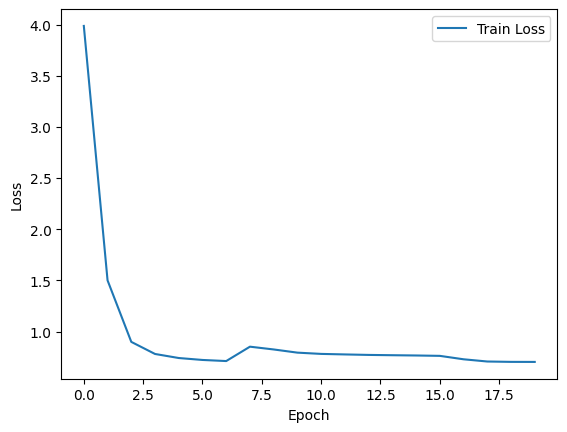

In [110]:
plt.plot(save_loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. 모델 평가

In [111]:
new_model = torch.load('/content/drive/MyDrive/Playdata_Python/final_project/models/summary_dataset/summary_model_v1_1.pth')

In [114]:
new_model.eval()  # 모델을 평가 모드로 설정

epoch_loss = 0.0

with torch.no_grad():  # 그라디언트 업데이트 비활성화

    for batch in valid_dl:
        try:
            input_ids = batch['input_ids'].to(device)
            decoder_input_ids = batch['decoder_input_ids'].to(device)

            logits = new_model(input_ids, decoder_input_ids).logits

            # 패딩을 제거하고 실제 레이블을 얻기 위해 decoder_input_ids에서 패딩 토큰을 제거
            labels = decoder_input_ids[:, 1:].contiguous()  # 시작 토큰을 제외하고 실제 레이블을 가져옴

            # 손실 계산
            logits_flat = logits.view(-1, logits.shape[-1])  # 로짓 텐서를 얻고나서 view 메서드 적용
            labels_flat = labels.view(-1)
            loss = criterion(logits_flat[:labels_flat.shape[0]], labels_flat)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

        except KeyboardInterrupt:
            print("KeyboardInterrupt: Exiting validation...")
            break

print(f'Validation Loss: {epoch_loss/len(valid_dl)}')

Validation Loss: 6.2557912674270755


In [112]:
original_sen_list[0]

'정은경 질병관리청장과 봉준호 감독이 미국의 시사주간지 타임(Time)이 선정하는 ‘2020 세계에서 가장 영향력 있는 100인’ 명단에 나란히 이름을 올렸다. 청와대 관계자는 23일 “이번 선정은 K방역이 전 세계가 본받아야 할 모범으로 인정받았다는 점을 확인해주는 데 의미가 있다”며 “방역과 관련해 뛰어난 성과와 업적을 보인다는 점에서 정 청장을 선정한 것”이라고 말했다. 정 청장은 리더스 부분에 등재됐다. 아티스트 부분에 이름을 올린 봉 감독에 대해서도 “매우 기쁜 소식이며 축하의 말씀을 전한다”고 했다. 특히 문재인 대통령은 정 청장에 대한 소개글을 타임에 전달했다. 선정된 100인 소개글 가운데 현직 대통령의 글은 문 대통령이 유일하다.  문 대통령은 소개글에서 “코로나19 팬데믹 상황에서 한국의 방역은 세계의 모범이 됐고, 정 청장은 방역의 최전방에서 국민과 진솔하게 소통해 K방역을 성공으로 이끌었다”고 적었다. 이어 “한국에 첫 확진자가 발생했을 때 정 청장은 정부를 대표해 국민 앞에 섰고 매일 투명하게 상황을 발표했다”며 “질병관리청 최초의 여성 수장으로서 코로나 발생 6개월 전부터 ‘원인불명 집단감염 대응절차’ 매뉴얼을 마련하는 등 질병관리청을 준비된 조직으로 이끌었다”고 평가했다. 문 대통령은 알베르 카뮈의 소설 『페스트』에 등장하는 ‘페스트와 싸우는 유일한 방법은 성실성’이라는 문구를 인용하며 “정 청장의 성실성이야말로 세계 곳곳에서 코로나와 맞서는 수많은 ‘정은경’들에게, 그리고 포스트 코로나 시대를 연 인류 모두에게 영감을 주는 얘기”라고 강조했다. 앞서 문 대통령은 지난 11일 충북 청주에 있는 질병관리본부(질본)를 찾아 정 청장에게 임명장을 수여했다. 정 청장은 차관급이다. 이번 정부 들어 장ㆍ차관급을 통틀어 문 대통령이 현장을 찾아 임명식을 진행한 것은 이때가 처음이다. 이와 관련 청와대 관계자는 “전쟁 중에 야전사령관을 불러 임명장을 주는 것이 아닌 직접 가서 임명장을 드리는 것이기 때문에 초대 청장에 대한 신뢰와 기대 의미를 갖

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 한글 텍스트를 토큰화하고 요약된 결과를 리스트에 저장
new_summary_sen_by_model_list = []

for original_sen in original_sen_list[:20]:
    # 문장을 토큰화
    input_ids = tokenizer.encode(original_sen, return_tensors="pt")
    input_ids = input_ids.to(device)

    # 모델을 사용하여 요약 생성
    summary_ids = new_model.generate(input_ids, max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True).to(device)
    summary_ids = summary_ids.to(device)

    # 요약 결과를 디코딩하여 텍스트로 변환
    summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    new_summary_sen_by_model_list.append(summary_text)

new_summary_sen_by_model_list[:5]

['로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로',
 '로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로',
 '로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로',
 '로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로',
 '로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로로']

In [63]:
# BLEU 점수 계산
nltk.download('punkt')

# 문장을 토큰 리스트로 변환하는 함수
def tokenize_sentence(sentence):
    return nltk.word_tokenize(sentence)

num_sentences = 20  # 20개로 test
total_belu_score = []

for i in range(num_sentences):

    # Reference 문장과 Candidate 문장 토큰화
    reference_tokens = tokenize_sentence(summary_sen_list[i])
    candidate_tokens = tokenize_sentence(new_summary_sen_by_model_list[i])

    # BLEU Score 계산
    bleu_score = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))  # (원본 번역문, 모델 번역문)
    total_belu_score.append(bleu_score)

    if i < 20:
        # BLEU 점수 출력
        print(f"{i}번째 | 원본 번역본: {summary_sen_list[i]}")
        print(f"{i}번째 | 모델 번역본: {new_summary_sen_by_model_list[i]}")
        print(f"{i}번째 | BLEU 점수: {bleu_score}")
        print("----------------------------------------------------------------------------------------------------")
    else:
        pass

# 전체 blue 평균 계산
average_bleu_score = sum(total_belu_score) / num_sentences
print(f"100문장에 대한 Belu Score 평균: {average_bleu_score}")

0번째 | 원본 번역본: 정 청장과 봉 감독이 2020 세계에서 가장 영향력 있는 100인 명단에 오르자 청와대 관계자는 K방역이 모범으로 인정받았음을 확인했다고 말하며 봉 감독에게는 축하를 전했다.
0번째 | 모델 번역본: 로로이이
0번째 | BLEU 점수: 0
----------------------------------------------------------------------------------------------------
1번째 | 원본 번역본: 인간을 탐구하는 학자와 같이 창업가는 고객이 집 등에서 어떤 행동을 하는지 관찰하고 어떤 부분에서 짜증을 느끼는지 공감하는 과정을 통해 기존에 없던 방식으로 혁신을 만든다.
1번째 | 모델 번역본: 로로
1번째 | BLEU 점수: 0
----------------------------------------------------------------------------------------------------
2번째 | 원본 번역본: 프랜차이즈 본사가 광고 · 판촉 행사를 하려면 미리 일정 비율 이상의 가맹점주 동의를 받아야 하며 신규 프랜차이즈 본부가 가맹점을 모집하려면 직영점을 1년 이상 운영해야 한다.
2번째 | 모델 번역본: 로로로
2번째 | BLEU 점수: 0
----------------------------------------------------------------------------------------------------
3번째 | 원본 번역본: 테슬라 최고 경영자가 테슬라 역사상 신나는 날이 될 것 이라고 트윗을 날린 뒤 배터리 데이는 테슬라 주가 상승을 견인한 호재 중 하나로 꼽았지만 뚜껑을 열어보니 정반대였다.
3번째 | 모델 번역본: 에로로에
3번째 | BLEU 점수: 0
----------------------------------------------------------------------------------------------------
4번째 | 원본

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
